## Анализ бизнес-показателей интернет платформы    
Проведение анализа для принятия решения по оптимизации маркетинговых затрат. Расчет Retention Rate, LTV, CAC, ROMI. Когортный анализ.   


#### Описание данных    
Таблица visits (лог сервера с информацией о посещениях сайта):   
**Uid** — уникальный идентификатор пользователя;   
**Device** — категория устройства пользователя;   
**Start Ts** — дата и время начала сессии;   
**End Ts** — дата и время окончания сессии;   
**Source Id** — идентификатор рекламного источника, из которого пришел пользователь.   
    
Таблица orders (информация о заказах):   
**Uid** — уникальный id пользователя, который сделал заказ;   
**Buy Ts** — дата и время заказа;   
**Revenue** — выручка с этого заказа.     
    
Таблица costs (информация о затратах на маркетинг):   
**source_id** — идентификатор рекламного источника;   
**dt** — дата;    
**costs** — затраты на этот рекламный источник в этот день.    

#### Содержание   
* [Шаг 1. Загрузка данных. Изучение общей информации](#cell1)   
* [Шаг 2. Построение отчётов и подсчет метрик](#cell2)   
* [      2.1. Метрики продукта](#cell2.1)   
* [      2.2. Метрики продаж](#cell2.2)   
* [      2.3. Метрики маркетинга](#cell2.3)   
* [Шаг 3. Вывод: рекомендации маркетологам, куда и сколько им стоит вкладывать денег?](#cell3)     

### Шаг 1. Загрузка данных. Изучение общей информации <a id="cell1"></a>

In [1]:
# импорт библиотек
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# загрузка данных 
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [2]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
# перезапишим названия столбцов в нижнем регистре и с нижним подчеркиванием
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

In [5]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [6]:
# заменим тим данных даты и времени
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


В таблице visits пропусков нет, названия столбцов отредактированны, тип данных даты и время заменены. 

In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
# перезапишим названия столбцов
orders.columns = ['buy_ts', 'revenue', 'uid']

In [11]:
# заменим тим данных
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

В таблице orders пропусков нет, названия столбцов отредактированны, тип данных заменен. 

In [12]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [14]:
# заменим тим данных
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

В таблице costs заменили тип данных.

In [15]:
# проверим дубликаты
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


### Вывод

В нашем распоряжении три таблицы visits, orders, costs. В таблицах отредактированы названия столбцов и типы данных. Пропусков и дубликатов нет. Данные готовы к проведению анализа и расчетов.

### Шаг 2. Построение отчётов и подсчет метрик <a id="cell2"></a>

#### 2.1. Метрики продукта <a id="cell2.1"></a>

**Посчитаем колличество уникальных пользователей в день, неделю, месяц**

In [16]:
# создадим столбцы год, месяц и неделю, а также полную дату.
visits['year']  = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week']  = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].dt.date

In [17]:
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Посчитаем колличество уникальных пользователей в день, неделю, месяц.

In [18]:
# сгруппируем данные по требуемым временным отрезкам и найдем среднее число уникальных пользователей
dau = int(visits.groupby('date').agg({'uid': 'nunique'}).mean())
wau = int(visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean())
mau = int(visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean())
# выведем значения
print('колличество уникальных пользователей в день - {}'.format(dau))
print('колличество уникальных пользователей в неделю - {}'.format(wau))
print('колличество уникальных пользователей в месяц - {}'.format(mau))

колличество уникальных пользователей в день - 907
колличество уникальных пользователей в неделю - 5716
колличество уникальных пользователей в месяц - 23228


**Посчитаем регулярность использования приложения**

In [19]:
#  посчитаем регулярность использования приложения в неделю
dau/wau

0.1586773967809657

In [20]:
#  посчитаем регулярность использования приложения в месяц
dau/mau

0.039047701050456345

In [21]:
# колличество сессий на одного пользователя в месяц
sessions_per_user = visits.groupby(['year', 'month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

n_sessions  n_users  sessions_per_user
year month                                        
2017 6           16505    13259           1.244815
     7           17828    14183           1.256998
     8           14355    11631           1.234202
     9           23907    18975           1.259921
     10          37903    29692           1.276539
     11          43969    32797           1.340641
     12          41983    31557           1.330386
2018 1           36939    28716           1.286356
     2           37182    28749           1.293332
     3           35679    27473           1.298693
     4           26515    21008           1.262138
     5           26635    20701           1.286653

In [22]:
# колличество сессий на одного пользователя в день
sessions_per_data = visits.groupby('date').agg({'uid': ['count','nunique']})
sessions_per_data.columns = ['n_sessions', 'n_users']
sessions_per_data['sessions_per_data'] = sessions_per_data['n_sessions'] / sessions_per_data['n_users']
sessions_per_data

,n_sessions,n_users,sessions_per_data
date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


In [23]:
print('Среднее колличество сессий на 1 пользователя в день - {:.2f}'.format(sessions_per_data['sessions_per_data'].mean()))
print('Среднее колличество сессий на 1 пользователя в месяц - {:.2f}'.format(sessions_per_user['sessions_per_user'].mean()))

Среднее колличество сессий на 1 пользователя в день - 1.08
Среднее колличество сессий на 1 пользователя в месяц - 1.28


**Посчитаем длительность одной сессии**

In [24]:
#Средняя продолжительность сессии или ASL
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Средняя продолжительность сессии - {:.0f} сек.'.format(visits['session_duration_sec'].mean()))
print('Медианная продолжительность сессии - {:.0f} сек.'.format(visits['session_duration_sec'].median()))
print('Самое популярное значение продолжительности сессии (мода) - {} сек.'.format(int(visits['session_duration_sec'].mode())))

Средняя продолжительность сессии - 644 сек.
Медианная продолжительность сессии - 300 сек.
Самое популярное значение продолжительности сессии (мода) - 60 сек.


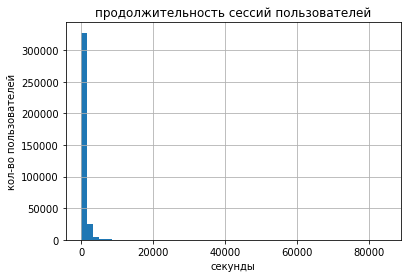

In [25]:
# построим гистограмму продолжительности сессии
visits['session_duration_sec'].hist(bins=50)
plt.title("продолжительность сессий пользователей")
plt.xlabel("секунды") 
plt.ylabel("кол-во пользователей")
plt.show()

Из-за выбросов, моду на гистограмме не видно, возьмем срез поменьше 

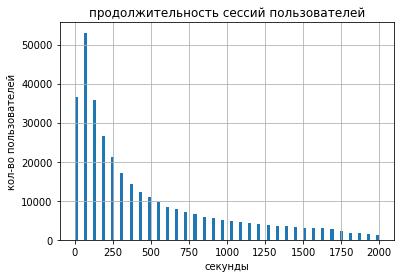

In [26]:
visits['session_duration_sec'].hist(bins=100, range=(0,2000))
plt.title("продолжительность сессий пользователей")
plt.xlabel("секунды") 
plt.ylabel("кол-во пользователей")
plt.show()

График имеет вид распределения Пуассона.   
Итого, из-за выбросов наше среднее и медианное значение длительности сессии завышено. Больше всего сессий длится по 60 сек. Т.е. человек заходит смотрит и сразу уходит, это перспективная точка роста, а на данный момент слабое место. Либо человек совершает нецелевые заходы и попадает на ненужный сервис, а  это трата рекламного буджета. Возможно посетителю сложно разобраться в сервисе и он уходит.

**Расчитаем Retention Rate (коэффициент удержания)**

In [27]:
#  определим первый день использования приложения пользователем
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.merge(first_activity_date,on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:05:00


In [28]:
#  определим месяц использования приложения и месяц первого использования приложения
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
#  определим сколько месяцев пользовались приложением
visits['lifetime_month'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['lifetime_month'] =  visits['lifetime_month'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,session_duration_sec,first_activity_date,activity_month,first_activity_month,lifetime_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0


In [29]:
#  определим когорты
cohorts = visits.groupby(['first_activity_month','lifetime_month']).agg({'uid':'nunique'}).reset_index()
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.date

# рассчитаем количество пользователей в когорте
initial_users_count = cohorts[cohorts['lifetime_month'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] * 100
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='lifetime_month',
                                      values='retention',
                                      aggfunc='sum')
#retention_pivot.fillna('')

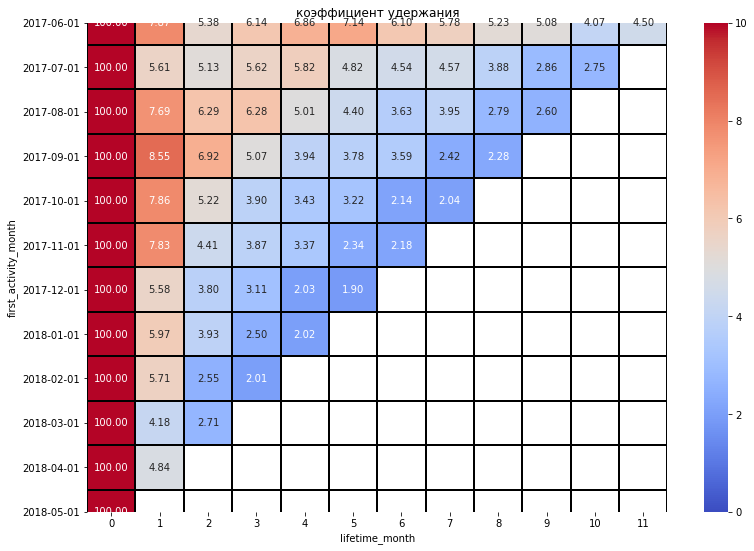

In [88]:
plt.figure(figsize=(13, 9))
plt.title('коэффициент удержания')
sns.heatmap(retention_pivot, annot=True, fmt='.2f', linewidths=1,
            linecolor='black', vmin=0, vmax=10, center= 5, cmap= 'coolwarm')

По коэффициенту удержания видно, что в первый месяц уходит более 90% пользователей - это очень много. По первому месяцу пользования видно, что в 2018 году коэф. удержания упал. НА графике можно выделить диагональ ноября 2017 года, проводимые мероприятия помогли вернуть пользователей кагорт. В когортах показатель удержания с каждым месяцем падает.  

#### 2.2. Метрики продаж <a id="cell2.2"></a>

**Когда люди начинают покупать?**

In [31]:
# найдем день первой покупки пользователя
first_buy_date = orders.groupby(['uid'])['buy_ts'].min()
first_buy_date.name = 'first_buy_date'
# обьединим в таблице,столбцы первого дня пользования сервисом и день первой покупки по  id пользователя
visits_buy = pd.merge(first_activity_date,first_buy_date, on='uid')

In [32]:
# преобразуем столбцы в дату
visits_buy['first_activity_date'] = visits_buy['first_activity_date'].astype('datetime64[D]')
visits_buy['first_buy_date'] = visits_buy['first_buy_date'].astype('datetime64[D]')
# найдем колличество дней между первым визитом и покупкой
visits_buy['time_to_purchase'] = (visits_buy['first_buy_date'] - visits_buy['first_activity_date']) / np.timedelta64(1, 'D')
visits_buy['time_to_purchase'] = visits_buy['time_to_purchase'].astype('int')
visits_buy.head()

,first_activity_date,first_buy_date,time_to_purchase
uid,,,
313578113262317,2017-09-18,2018-01-03,107
1575281904278712,2017-06-03,2017-06-03,0
2429014661409475,2017-10-11,2017-10-11,0
2464366381792757,2018-01-27,2018-01-28,1
2551852515556206,2017-11-24,2017-11-24,0


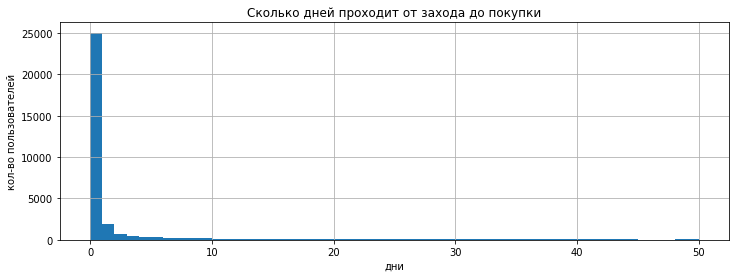

In [33]:
# построим гистограмму
visits_buy['time_to_purchase'].hist(bins=50,figsize = (12,4),range=(0,50))
plt.title("Сколько дней проходит от захода до покупки")
plt.xlabel("дни") 
plt.ylabel("кол-во пользователей")
plt.show()

In [34]:
print('Среднее кол-во дней до покупки - {:.0f} дней'.format(visits_buy['time_to_purchase'].mean()))
print('Медианное кол-во дней до покупки - {:.0f} дней'.format(visits_buy['time_to_purchase'].median()))

Среднее кол-во дней до покупки - 17 дней
Медианное кол-во дней до покупки - 0 дней


In [35]:
#посмотрим уникальные значения в % соотношении
visits_buy['time_to_purchase'].value_counts( normalize = True).head(10)

0    0.685568
1    0.053829
2    0.018755
3    0.012376
4    0.010569
5    0.008406
6    0.007228
7    0.006489
8    0.005914
9    0.004436
Name: time_to_purchase, dtype: float64

В основном покупки совершаются сразу, нашел-купил около 68%, Вероятно, изучив и сравнив предложения клиенты возращаются через день 5% и через 2,3,4 дня примерно по 1% от общего числа покупателей.То есть чем человек дольше ищет товар и изучает сервис,  тем меньше шанс совершения покупки.

**Сколько денег приносят? (LTV)**

In [36]:
#  сформируем месячные когорты
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [37]:
#  месяц первой покупки каждого покупателя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

#  найдем, сколько людей совершили покупку впервые в каждом месяце
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# добавим дату первой покупки с помощью метода merge() к датафрейму orders
orders_first_month = pd.merge(orders,first_orders, on='uid')

# cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим доход
#cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts = (orders_first_month.groupby(['first_order_month','order_month'])['revenue']
                    .agg(['sum', 'count'])
                    .rename(columns={"sum": "revenue", "count": "number_purchases"})
                    .reset_index())

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

# создадим столбец возраст (age) когорты
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

# посчитаем LTV: выручку поделим на кол-во покупателей
report['ltv'] = report['revenue'] / report['n_buyers']


report['first_order_month'] = report['first_order_month'].dt.date
result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean')
    

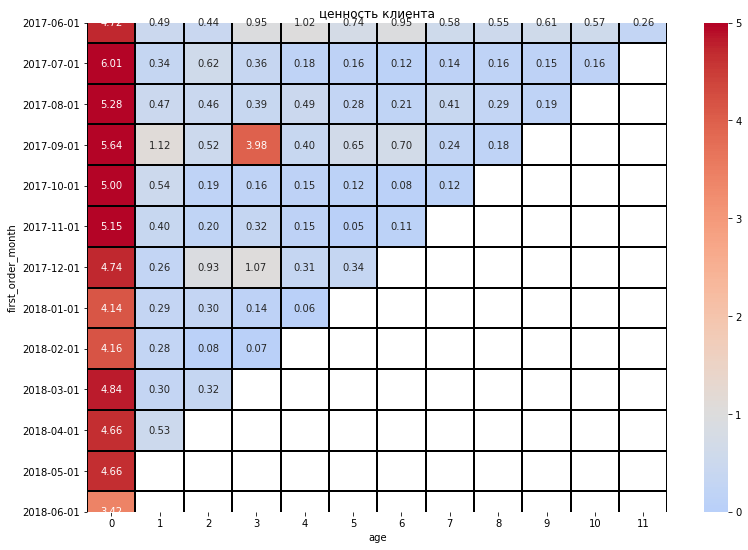

In [38]:
plt.figure(figsize=(13, 9))
plt.title('ценность клиента')
sns.heatmap(result, annot=True, fmt='.2f', linewidths=1,
            linecolor='black', vmin=0, vmax=5, center= 1, cmap= 'coolwarm')

In [39]:
# посчитаем ценность за весь период жизни когорты
ltv_sum=result.loc[:,0:11].sum(axis=1)
ltv_sum

first_order_month
2017-06-01    11.879234
2017-07-01     8.386854
2017-08-01     8.471723
2017-09-01    13.435227
2017-10-01     6.360242
2017-11-01     6.395244
2017-12-01     7.639913
2018-01-01     4.940151
2018-02-01     4.587921
2018-03-01     5.455253
2018-04-01     5.189196
2018-05-01     4.660562
2018-06-01     3.420000
dtype: float64

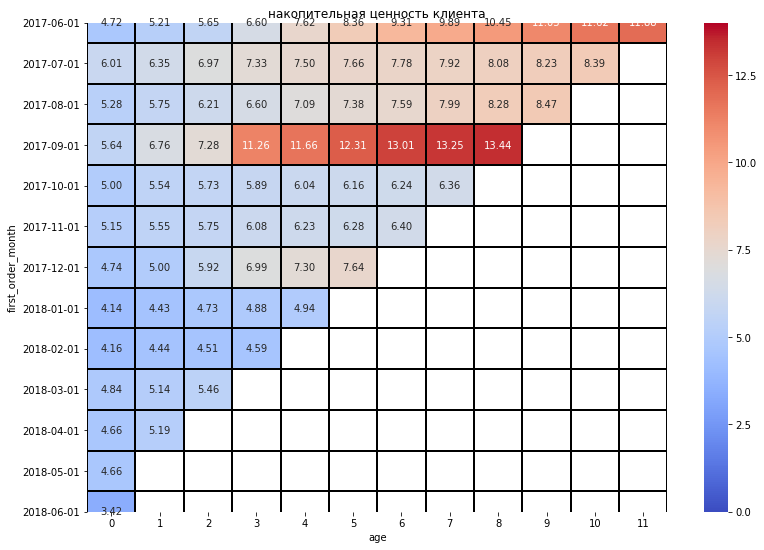

In [40]:
# посчитаем накопительную ценность клиента
plt.figure(figsize=(13, 9))
plt.title('накопительная ценность клиента')
sns.heatmap(result.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1,
            linecolor='black', vmin=0, vmax=14, center= 7, cmap= 'coolwarm')

In [41]:
# посчитаем ценность по периодам жизни
result.cumsum(axis=1).mean(axis=0)

age
0      4.801682
1      5.395666
2      5.821811
3      6.689763
4      7.298634
5      7.969053
6      8.387686
7      9.083583
8     10.062084
9      9.251340
10    10.004616
11    11.879234
dtype: float64

С увеличением возраста когорты ценность клиента в конкретный месяц стремится к нулю. К 8-9 месяцу ценность клиента начинает стагнировать и почти не изменяется. На старте когорты почти не отличаются и приносят от 4 до 6.  В хаотичном порядке появляются месяца жизни когорт, где происходят всплески показателей. Возможно в эти месяца проводились маркетинговые акции, а может несколько клиентовхорошенько потратились.

**Сколько раз покупают за период?**

In [42]:
# посчитаем выручку за месяц и число покупок в месяц
orders_first_month['first_order_month'] = orders_first_month['first_order_month'].dt.date
orders_first_month['order_month'] = orders_first_month['order_month'].dt.date
revenue_month = orders_first_month.groupby(['first_order_month','order_month'])['revenue'].agg(['sum', 'count'])
revenue_month.columns  = ['sum_revenue_month', 'count_revenue_month']
# средний чек 
revenue_month['average_check'] = revenue_month['sum_revenue_month'] / revenue_month['count_revenue_month'] 
revenue_month

sum_revenue_month  count_revenue_month  \
first_order_month order_month                                           
2017-06-01        2017-06-01             9557.49                 2354   
                  2017-07-01              981.82                  177   
                  2017-08-01              885.34                  174   
                  2017-09-01             1931.30                  226   
                  2017-10-01             2068.58                  292   
...                                          ...                  ...   
2018-03-01        2018-05-01             1114.87                  176   
2018-04-01        2018-04-01            10600.69                 2495   
                  2018-05-01             1209.92                  195   
2018-05-01        2018-05-01            13925.76                 3249   
2018-06-01        2018-06-01                3.42                    1   

                               average_check  
first_order_month order_month                 
2017-06-01        2017-06-01        4.060106  
                  2017-07-01        5.547006  
                  2017-08-01        5.088161  
                  2017-09-01        8.545575  
                  2017-10-01        7.084178  
...                                      ...  
2018-03-01        2018-05-01        6.334489  
2018-04-01        2018-04-01        4.248774  
                  2018-05-01        6.204718  
2018-05-01        2018-05-01        4.286168  
2018-06-01        2018-06-01        3.420000  

[79 rows x 3 columns]

Построим heatmap 'выручки когорт по месяцам'

In [43]:
cohorts_revenue = revenue_month.pivot_table(
    index='first_order_month', 
    columns='order_month', 
    values='sum_revenue_month')

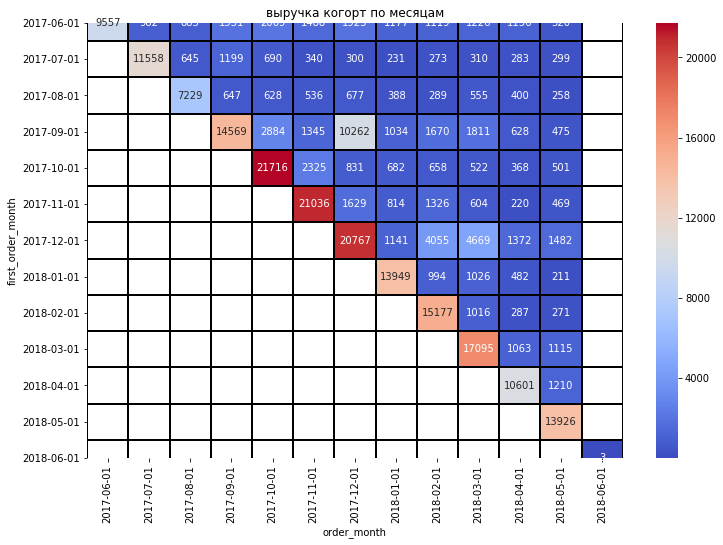

In [44]:
plt.figure(figsize=(12, 8))
plt.title('выручка когорт по месяцам')
sns.heatmap(cohorts_revenue, annot=True, fmt='.0f', linewidths=1,
            linecolor='black', cmap= 'coolwarm')

Построим heatmap 'числа покупок в когорте по месяцам'

In [45]:
cohorts_counts_check = revenue_month.pivot_table(
    index='first_order_month', 
    columns='order_month', 
    values='count_revenue_month')

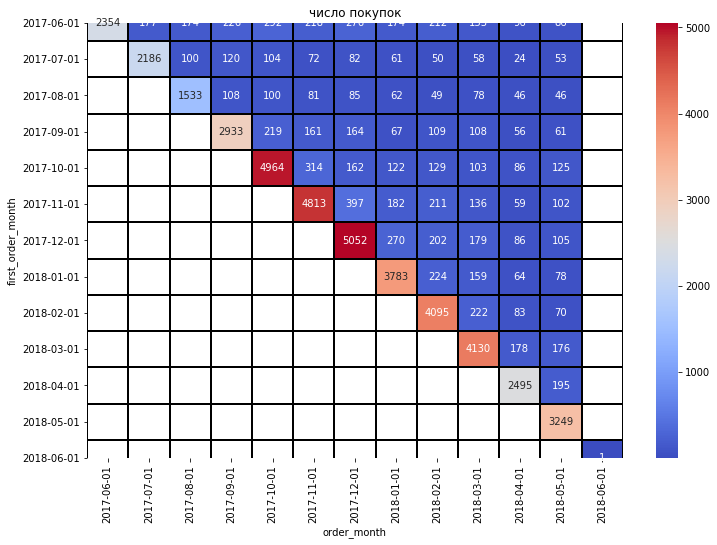

In [46]:
plt.figure(figsize=(12, 8))
plt.title('число покупок')
sns.heatmap(cohorts_counts_check, annot=True, fmt='.0f', linewidths=1,
            linecolor='black', cmap= 'coolwarm')

Построим heatmap 'Средний чек в когорте по месяцам'

In [47]:
cohorts_average_check = revenue_month.pivot_table(
    index='first_order_month', 
    columns='order_month', 
    values='average_check')

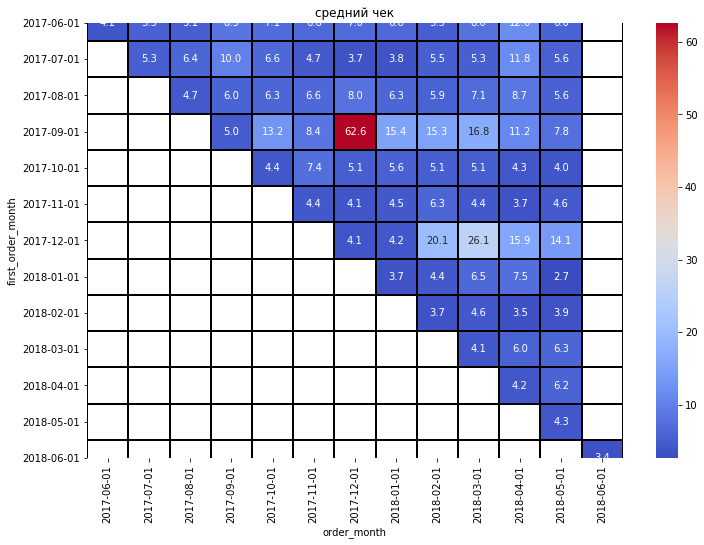

In [48]:
plt.figure(figsize=(12, 8))
plt.title('средний чек')
sns.heatmap(cohorts_average_check, annot=True, fmt='.1f', linewidths=1,
            linecolor='black', cmap= 'coolwarm')

In [49]:
print('Средняя выручка в месяц - {:.2f}'.format(revenue_month['sum_revenue_month'].mean()))
print('Среднее число покупок в месяц - {:.0f}'.format(revenue_month['count_revenue_month'].mean()))
print('Средний чек покупки - {:.2f}'.format(revenue_month['average_check'].mean()))

Средняя выручка в месяц - 3190.60
Среднее число покупок в месяц - 638
Средний чек покупки - 7.65


Из графиков видно, что первый месяц жизни когорты самый продуктивный по выручке и числу покупок. На общем фоне выделяется когорта 2017-09 где средний чек выше среднего. Также выделим высокое колличество покупок в первом месяце когорт 2017-10, 2017-11, 2017-12

In [50]:
# посчитаем выручку с одного клиента
average_revenue = orders.groupby(['uid'])['revenue'].agg(['sum'])
average_revenue['sum'].mean()

6.901327930345157

In [51]:
# посчитаем среднее число покупок одного клиента
n_purchases = orders.groupby(['uid'])['revenue'].agg(['count'])
n_purchases['count'].mean()

1.3803630588943954

In [52]:
# посчитаем средний чек со всех покупок
orders['revenue'].mean()

4.999646930476993

In [53]:
# возьмем группировку данных из предыдущего задания
report.head()

,first_order_month,n_buyers,order_month,revenue,number_purchases,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,2354,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,177,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,174,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,226,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,292,4,1.022531


In [54]:
# посчитаем выручку в когортах
result2 = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='revenue')

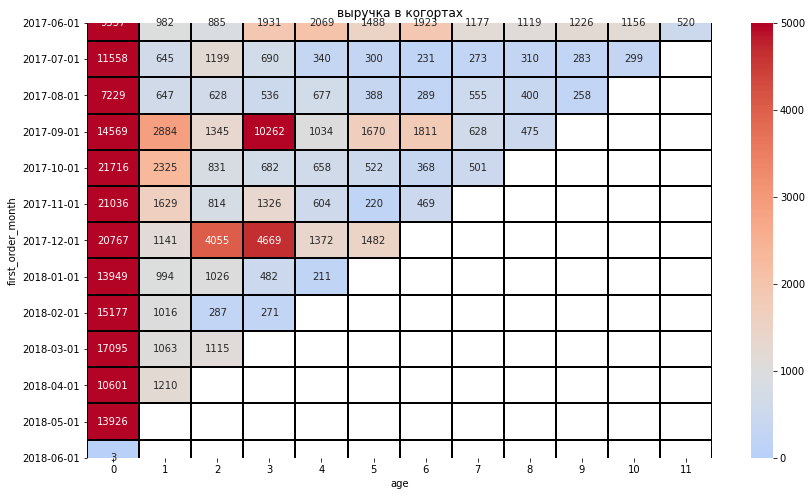

In [55]:
plt.figure(figsize=(14, 8))
plt.title('выручка в когортах')
sns.heatmap(result2, annot=True, fmt='.0f', linewidths=1,
            linecolor='black', cmap= 'coolwarm', vmin=0, vmax=5000, center= 1000)

In [56]:
# посчитаем число покупок в когортах
result3 = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='number_purchases')

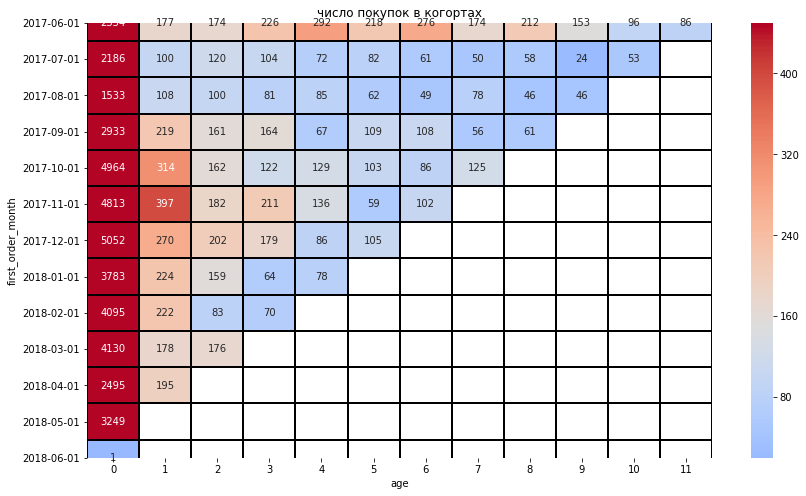

In [57]:
plt.figure(figsize=(14, 8))
plt.title('число покупок в когортах')
sns.heatmap(result3, annot=True, fmt='.0f', linewidths=1,
            linecolor='black', cmap= 'coolwarm', vmin=20, vmax=450, center= 150)

Из графика видно, что на старте в летние месяцы меньшее число покупок (и вероятно мероприятий проводится меньше, активные клиенты уезжают  в отпуска). С сентябрьских когорт начинается постепенный рост продадаж с пиком в декабре. В декабре заметен и небольшой общий рост числа покупок.

Cреднее число покупок на клиента равно 1.38, средний чек покупки составляет 4.99. Сервис имеет небольшую сезонность, спад летом, рост с октября по март.

#### 2.3. Метрики маркетинга <a id="cell2.3"></a>

**Сколько денег потрачено? Всего / на каждый источник / по времени**

In [58]:
# Выделим расходы по месяцам
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['month'] = costs['month'].dt.date

In [59]:
print('расходы всего - {:.1f}'.format(costs['costs'].sum()))
print('рентабельность - {:.1f}'.format(orders['revenue'].sum()/costs['costs'].sum()))

расходы всего - 329131.6
рентабельность - 0.8


In [60]:
# расходы по месяцам
monthly_costs = costs.groupby('month')['costs'].sum()
monthly_costs

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [61]:
# расходы по рекламным источникам
source_id_costs = costs.groupby('source_id')['costs'].sum()
source_id_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Всего на маркетинг потрачено - 329131, рентабельность вложений  - 0.8, т.е. рекламные компании убыточны. Самые  большие расходы были  в октябре, ноябре, декабре 2017г. Большего всего затрат было на 3 рекламный источник, меньше всего на 9, 10.

**Узнаем сколько стоило привлечение одного покупателя 'cac' и возврат на маркетинговые инвестиции ROMI по когортам**

In [62]:
# найдем затраты на привлечение 1 клиента 'cac'
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
# найдем ROMI (возврат на маркетинговые инвестиции)
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')


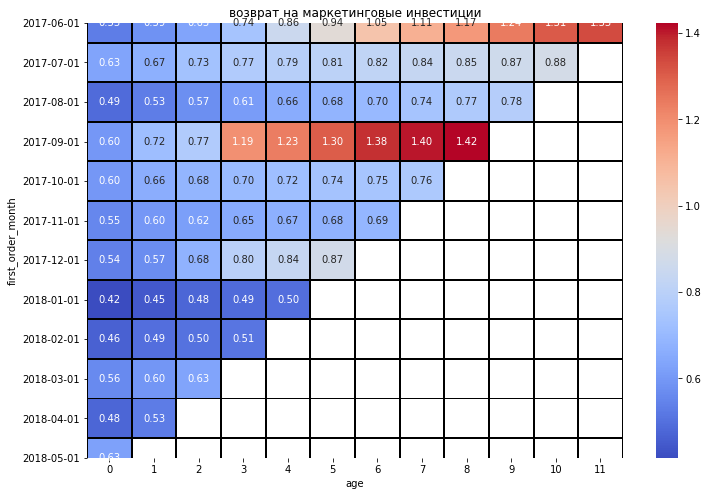

In [63]:
plt.figure(figsize=(12, 8))
plt.title('возврат на маркетинговые инвестиции')
sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1,
            linecolor='black', cmap= 'coolwarm')

Из таблицы видно, что вернуть рекламные затраты, смогли только с двух когорт 2017-06  на 7 месяц и 2017-09 на 4 месяц

In [64]:
# выделим когорты, которые прожили 6 месяцев и сравним их. Сделаем срез.
report_new['first_order_month'] = report_new['first_order_month'].astype('datetime64')
report_new_6 = report_new[(report_new['first_order_month'] <'2018-01-01') & (report_new['age'] <6)]
# сгруппируем 
output_6 = report_new_6.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

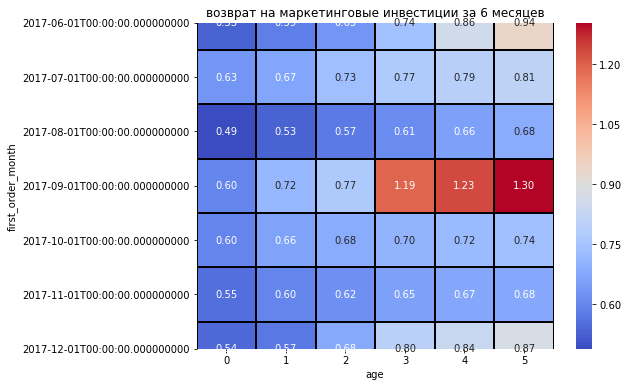

In [65]:
plt.figure(figsize=(8, 6))
plt.title('возврат на маркетинговые инвестиции за 6 месяцев')
sns.heatmap(output_6.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1,
            linecolor='black', cmap= 'coolwarm')

Худшие когорты по показателю 'romi' август и ноябрь 2017г. Как мы помним в августе самыя низкая выручка, и клиенты не активны, поэтому когорта изначальна слаба, а ноябрьскую когорту тащат вниз большие рекламные затраты, т.к. в зимний период самые большие расходы.  

**Найдем стоимость привлечения одного покупателя из каждого источника**

In [66]:
# найдем пользователей, которые делали покупки
buyers = (visits[visits['uid'].isin(orders['uid'].unique())]
         .sort_values(by = ['uid', 'start_ts']).groupby('uid')
         .agg({'start_ts': 'first', 'source_id': 'first', 'device': 'first'})
         .rename(columns = {'start_ts' : 'buyers_ts'})
         )
# объединим таблицы по источнику и дате
buyers['dt'] = buyers['buyers_ts'].dt.date
buyers['buyers_month'] = buyers['buyers_ts'].astype('datetime64[M]')
buyers =(buyers.reset_index().set_index(['source_id', 'dt'])
         .join(costs.set_index(['source_id', 'dt']), how = 'left'))


In [67]:
buyers.head()

uid           buyers_ts   device  \
source_id dt                                                             
1         2017-06-01   469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01  1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01  1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01  2050423809815667474 2017-06-01 10:36:00  desktop   
          2017-06-01  3520273333047097992 2017-06-01 20:08:00  desktop   

                     buyers_month  costs       month  
source_id dt                                          
1         2017-06-01   2017-06-01   75.2  2017-06-01  
          2017-06-01   2017-06-01   75.2  2017-06-01  
          2017-06-01   2017-06-01   75.2  2017-06-01  
          2017-06-01   2017-06-01   75.2  2017-06-01  
          2017-06-01   2017-06-01   75.2  2017-06-01

In [68]:
# сгруппируем по источнику, дате и найдем число пользователей и затраты
user_cost = (buyers.groupby(['source_id', 'dt'])
         .agg({'device': 'count', 'costs': 'max'})
         .rename(columns = {'device' : 'n_users'})
         )
user_cost['cac'] = user_cost['costs'] / user_cost['n_users']

# объединим таблицы
buyers = buyers.join(user_cost[['cac']], how = 'left')
buyers = buyers.reset_index().set_index('uid')[['buyers_ts', 'dt','buyers_month','source_id','device', 'cac']]

# добавим в таблицу выручку по id клиента
buyers = (buyers.join(orders.groupby('uid')
         .agg({'revenue': 'sum'})
         .rename(columns = {'revenue' : 'total_revenue'}), how = 'left'))

In [69]:
# сгруппируем значения device и определим стоимость привлечения одного покупателя
buyers.groupby('device').agg({'cac': 'mean'})

,cac
device,
desktop,9.010033
touch,8.757168


In [70]:
# сгруппируем значения device и определим на одинаковое кол-во людей затраты по источнику и выручку
device_romi = buyers.groupby('device').agg({'cac': 'sum', 'total_revenue': 'sum'})
# найдем romi для device 
device_romi['romi'] = device_romi['total_revenue'] / device_romi['cac']
device_romi

,cac,total_revenue,romi
device,,,
desktop,263183.050559,211329.77,0.802976
touch,64032.409441,40727.43,0.636044


In [71]:
# сгруппируем значения по источникам и определим стоимость привлечения одного покупателя
buyers.groupby('source_id').agg({'cac': 'mean'})

,cac
source_id,
1,7.171449
2,12.176372
3,13.493901
4,5.930255
5,7.467378
7,NaN
9,3.858318
10,4.064169


Самая дорогая стоимость привлечения у 2 и 3 источника, что в 2, 3 раза больше стоимости привлечения  4,9, 10 источника. У desktop и touch стоимость привлечения примерно равна, а вот возрат на маркетинговые инвестиции у desktop на 17% больше, чем у touch, это значит что выручка от клиентов desktop больше. 

#### Узнаем по каким каналам окупились расходы.

In [72]:
# сгруппируем значения по источникам и определим на одинаковое кол-во людей затраты по источнику и выручку
source_id_romi = buyers.groupby('source_id').agg({'cac': 'sum', 'total_revenue': 'sum'})
# найдем romi для источников 
source_id_romi['romi'] = source_id_romi['total_revenue'] / source_id_romi['cac']
source_id_romi

,cac,total_revenue,romi
source_id,,,
1,20790.03,31090.55,1.495455
2,42690.36,46923.61,1.099162
3,141321.63,54511.24,0.385725
4,61057.91,56696.83,0.928575
5,51756.40,52624.02,1.016764
7,0.00,1.22,inf
9,4197.85,5759.40,1.371988
10,5401.28,4450.33,0.823940


Сверим полученные цифры с суммами. 

In [73]:
orders['revenue'].sum()

252057.19999999998

In [74]:
source_id_romi['total_revenue'].sum()

252057.20000000406

In [75]:
source_id_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Выручка совпадает, затраты максимально близки с исходными данными. Значениям верим. 1 и 9 источник самые окупаемые, также минимально окупаемы 2 и 5 источник. От 3 источника нужно отказываться на него идут самые большие затраты, а выручка минимальна (ROMI = 0.38).

Немного поподробней рассмотрим метрики девайса и источников

In [76]:
# посмотрим по device количество бесполезных сессий, короче 4 секунд 
visits[visits['session_duration_sec'] < 4]['device'].value_counts(normalize=True)

desktop    0.661815
touch      0.338185
Name: device, dtype: float64

У desktop доля от всех плохих сессий 66% - возможно стоит посмотреть на юзабилити приложения

Сгруппируем значения и узнаем среднюю выручку рекламных источников по месяцам

In [77]:
total_revenue_source = buyers.pivot_table(
    index='buyers_month', 
    columns='source_id', 
    values='total_revenue', 
    aggfunc='mean')
total_revenue_source

source_id,1,2,3,4,5,7,9,10
buyers_month,,,,,,,,
2017-06-01,41.294542,20.819679,6.618172,14.894436,10.607171,NaN,7.191364,2.848496
2017-07-01,12.723967,10.700216,6.151549,6.022774,6.824637,NaN,6.759100,4.675082
2017-08-01,20.827540,7.111793,5.774116,5.746499,9.229130,1.22,5.479029,5.119556
2017-09-01,9.737782,15.452368,6.666487,5.641662,22.882809,NaN,7.908814,2.768958
2017-10-01,9.292286,11.288643,5.137043,4.931750,5.764804,NaN,4.492314,2.808909
2017-11-01,7.340514,9.558200,5.008528,5.440187,5.075355,NaN,4.220974,4.728043
2017-12-01,6.392409,39.005659,4.791237,4.415709,5.161511,NaN,4.558696,3.689600
2018-01-01,4.661396,8.103659,4.383983,4.001117,5.086329,NaN,3.340909,3.589126
2018-02-01,5.881772,6.819809,4.460672,4.518565,4.521686,NaN,4.862115,2.317876


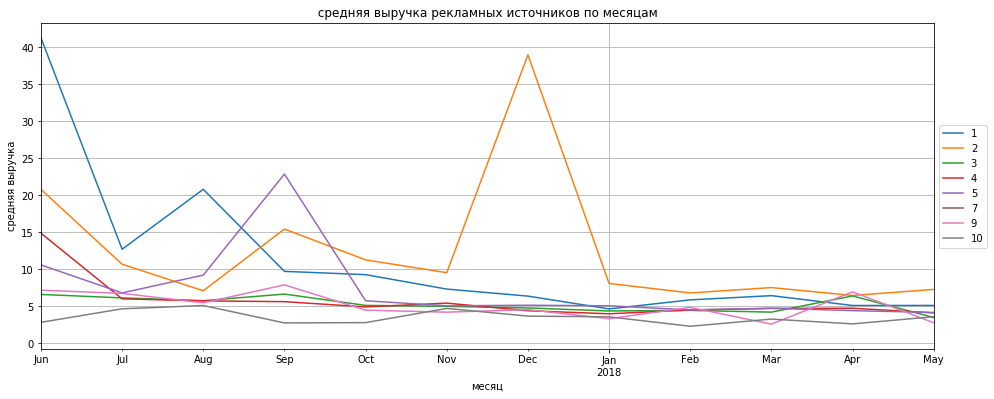

In [78]:
# на основе сводной таблицы построим  график
total_revenue_source.plot(figsize = (16,6), grid = True)
plt.title(" средняя выручка рекламных источников по месяцам ")
plt.xlabel("месяц") 
plt.ylabel("средняя выручка")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5 ))
plt.show()

Виден всплеск средней выручки у  1, 5 и 2 источника. Остальные рекламные источники идут в одной полосе и имеют низкую выручку. 

Сгруппируем значения и определим САС рекламных источников по месяцам

In [79]:
cac_source = buyers.pivot_table(
    index='buyers_month', 
    columns='source_id', 
    values='cac', 
    aggfunc='mean')
cac_source

source_id,1,2,3,4,5,9,10
buyers_month,,,,,,,
2017-06-01,4.509875,6.490321,8.726467,5.432457,5.139725,1.749545,2.470354
2017-07-01,5.830870,8.392482,11.540406,5.236988,6.044637,2.031900,4.187377
2017-08-01,7.554048,11.692207,13.743937,7.715492,5.000641,1.999223,3.802000
2017-09-01,6.056492,11.224286,10.543439,7.438768,5.602824,2.743729,4.599792
2017-10-01,6.616429,11.535714,12.440506,5.016281,5.643249,4.763223,2.843318
2017-11-01,7.387190,12.768078,13.405780,4.203448,9.357012,3.869091,5.693986
2017-12-01,7.137805,14.664072,13.371410,5.949241,7.925128,5.973478,7.599067
2018-01-01,9.847658,16.901382,15.855225,5.976219,9.213585,6.718182,5.399612
2018-02-01,8.679055,17.077634,14.945966,6.025274,8.382331,7.243077,4.194159


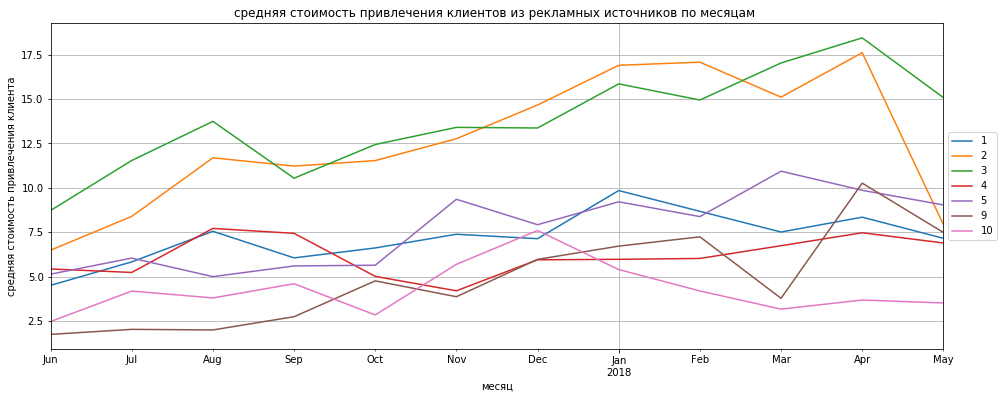

In [80]:
# на основе сводной таблицы построим  график
cac_source.plot(figsize = (16,6), grid = True)
plt.title("средняя стоимость привлечения клиентов из рекламных источников по месяцам ")
plt.xlabel("месяц") 
plt.ylabel("средняя стоимость привлечения клиента")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5 ))
plt.show()

2 и 3 источник самые дорогие. почти по всем источникам наблюдается медленный рост стоимости привлечения, что может говорить о неэффективном использовании рекламных бюджетов.

Посчитаем среднюю стоимость привлечения клиентов и среднюю выручку для device

In [81]:
revenue_device = buyers.pivot_table(
    index='buyers_month', 
    columns='device', 
    values='total_revenue', 
    aggfunc='mean')
revenue_device

device,desktop,touch
buyers_month,,
2017-06-01,14.831852,8.623918
2017-07-01,7.342570,6.905667
2017-08-01,7.454626,9.365378
2017-09-01,12.104011,6.914751
2017-10-01,6.022495,5.663109
2017-11-01,5.834951,5.288119
2017-12-01,8.349902,4.766378
2018-01-01,4.826859,4.051053
2018-02-01,4.941965,3.967877


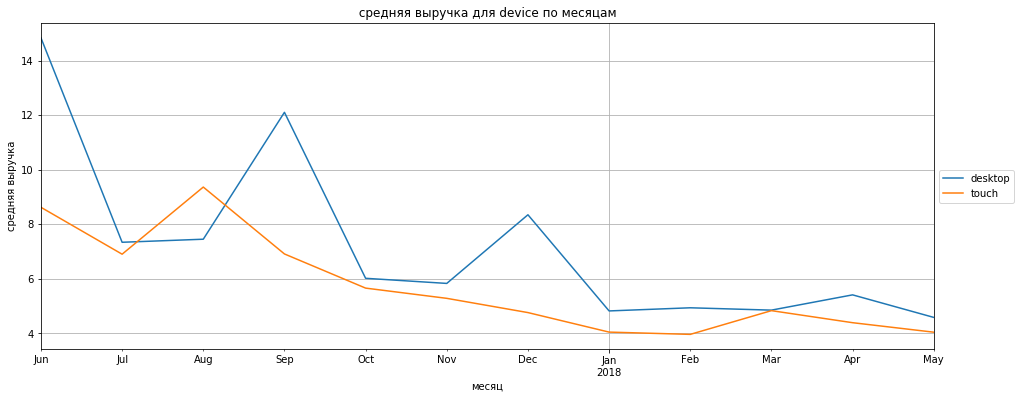

In [82]:
# на основе сводной таблицы построим  график
revenue_device.plot(figsize = (16,6), grid = True)
plt.title(" средняя выручка для device по месяцам ")
plt.xlabel("месяц") 
plt.ylabel("средняя выручка")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5 ))
plt.show()

Средняя выручка для пользователей desktop выше, чем у touch

In [83]:
cac_device = buyers.pivot_table(
    index='buyers_month', 
    columns='device', 
    values='cac', 
    aggfunc='mean')
cac_device

device,desktop,touch
buyers_month,,
2017-06-01,6.174557,5.937001
2017-07-01,7.456049,6.974347
2017-08-01,8.464189,8.500336
2017-09-01,7.947509,7.876600
2017-10-01,7.822383,7.475004
2017-11-01,8.937255,8.594890
2017-12-01,9.361450,9.351994
2018-01-01,10.782248,10.252231
2018-02-01,10.139126,10.478120


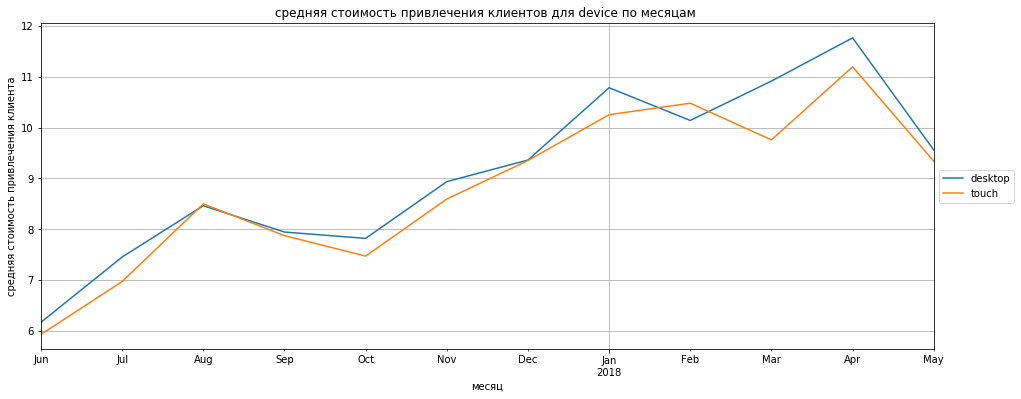

In [84]:
# на основе сводной таблицы построим  график
cac_device.plot(figsize = (16,6), grid = True)
plt.title("средняя стоимость привлечения клиентов для device по месяцам ")
plt.xlabel("месяц") 
plt.ylabel("средняя стоимость привлечения клиента")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5 ))
plt.show()

Средняя стоимость привлечения клиента для наших device почти не отличается.

### Вывод

Для маркетологов требуется оптимизировать маркетинговые затраты
На данный момент проект убыточен, рентабельность = 0.8. Для исправления ситуации, следует:  
- проанализировать когорты 2017-09 и 2017-12, где средний чек выше среднего
- отказаться от источника рекламы 3. Возможно отказаться от источника 4, 10 (или оставить для повышения узнаваемости сервиса в разных источниках)   
- проработать мероприятия для удержания клиента после первой покупки(потери после 1 месяца 90%)   
- из устройств предпочтительней desktop   
- разобраться в причинах плохих сессий, в особенности для desktop   
- 2 и 3 источники самые дорогие по стоимости привлечения клиента  
- в основном покупки совершаются сразу, нашел-купил около 68%
- ценность клиента, через 9 месяцев останавливается   
- расходы окупились по источникам 1,2,5,9  